# Explaining models

Predictive models have different properties. Some are designed to handle linear data. Others can mold to more complex input. Some models can be interpreted very easily; others are like black boxes and do not offer much insight into how the prediction is made. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
y_train = pd.read_excel('y_train.xls')
y_test = pd.read_excel('y_test.xls')
y = pd.read_excel('y.xls')
X = pd.read_excel('X.xls')
X_train = pd.read_excel('X_train.xls')
X_test = pd.read_excel('X_test.xls')

In [3]:
data = [y_test, y_train, y, X, X_test, X_train]
for d in data:
    d.drop(columns = 'Unnamed: 0', inplace = True)

## Regression coefficients 

The intercept and regression coefficients explain the expected value, and how features impact the prediction. A positive coefficient indicates that as feature's value increases, the prediction increases as well. 

## Feature Importance

Tree-based models i the scikit-learn library include a `.feature_importances_` attribute for inspecting how the features of a dataset affect the model. We can inspect or plot them. 

## Lime

LIME works to help explain black-box models. It performs a _local_ interpretation rather than an overall interpretation. It will help explain a single sample. 

For a given data point or sample, LIME indicates which features were important in determining the result. It does this by perturbing the sample in question and fitting a linear model to it. The linear model approximates the model close to the sample. 

In [4]:
# here is an example explaining the last sample (which our decision tree predicts will survive) from the training data 

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42, max_depth = 3)
dt.fit(X_train, y_train)

from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train.values,
                                             feature_names = X.columns,
                                              class_names = ['died','survived'])

exp = explainer.explain_instance(X_train.iloc[-1].values, dt.predict_proba)

# LIME does not like using DataFrames as input. Note that we converted the data to numpy arrays using .values

In [5]:
exp.show_in_notebook()

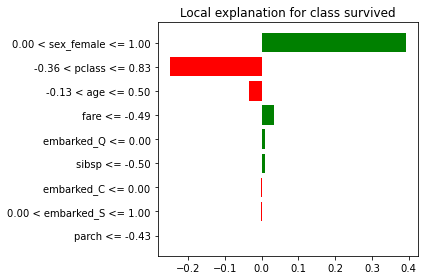

In [6]:
# We can create a matplotlib figure if we want to export the explanation 

fig = exp.as_pyplot_figure()
fig.tight_layout()

Play around with this and notice that if you switch geneders, the results are affected. Below we take the second to last row in the training data. The prediction for that raw is 48% deceased and 52%  survived. If we switch the gender, we find that the predeiction shift toward 87% deceased

In [7]:
data = X_train.iloc[-2].values.copy()
dt.predict_proba([data])

array([[0.48062016, 0.51937984]])

In [8]:
data[5] = 0 #change to male

In [9]:
dt.predict_proba([data])

array([[0.87954545, 0.12045455]])

## Tree interpretation

For sklearn tree-based models (decision tree, random forest, and extra tree models) you can use the treeinterpreter package. This will calculate the bias and the contribution from each feature. The bias in the mean of the training set.

Each contribution lists how it contributes to each of the labels. (The bias plus the contributions should sum to the prediction). 

Sunce this is a binary classification, there are only two. We see that `sex_female` is the most important followed by `fare`, `pclass` and `age`

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf5 = RandomForestClassifier(
**{
   'max_features': 'auto',
    'n_estimators': 200,
    'min_samples_leaf': 0.1,
    'random_state': 42, 
}
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

C:\Users\alber\AppData\Local\Temp/ipykernel_24752/2697999514.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf5.fit(X_train, y_train)


0.7150127226463104

In [14]:
from treeinterpreter import treeinterpreter as ti

instances = X.iloc[:2]
prediction, bias, contribs = ti.predict(rf5, instances)

i = 0
print('Instance', i)
print('Prediction', prediction[i])
print('Bias, (trainset mean)', bias[i])
print('Features contributions:')
for c, feature in zip(contribs[i], instances.columns):
    print(' {}  {}'.format(feature, c))

Instance 0
Prediction [0.83656418 0.16343582]
Bias, (trainset mean) [0.63887555 0.36112445]
Features contributions:
 pclass  [ 0.03631786 -0.03631786]
 age  [ 0.01458086 -0.01458086]
 sibsp  [ 0.00360379 -0.00360379]
 parch  [ 0.00525607 -0.00525607]
 fare  [ 0.04536969 -0.04536969]
 sex_female  [ 0.0809168 -0.0809168]
 embarked_S  [ 0.00530462 -0.00530462]
 embarked_Q  [0. 0.]
 embarked_C  [ 0.00633894 -0.00633894]


## Partial dependence plot 

With feature importance in trees we know that a feature is impacting the outcome, but we do not know how the impact varies as the feature's value changes. Partial dependence plots allow us to visualize the relation between changes in just one feature and the outcome. We will use pdpbox to visualize age effects survival. 

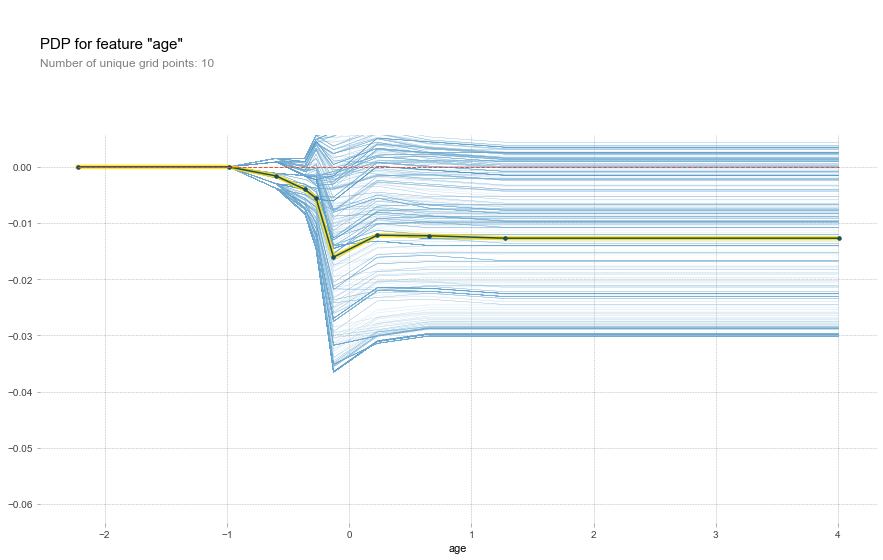

In [22]:
from pdpbox import pdp
feat_name = 'age'
p = pdp.pdp_isolate(rf5, X, X.columns, feat_name)

fig, _ = pdp.pdp_plot(p, feat_name, plot_lines = True) 

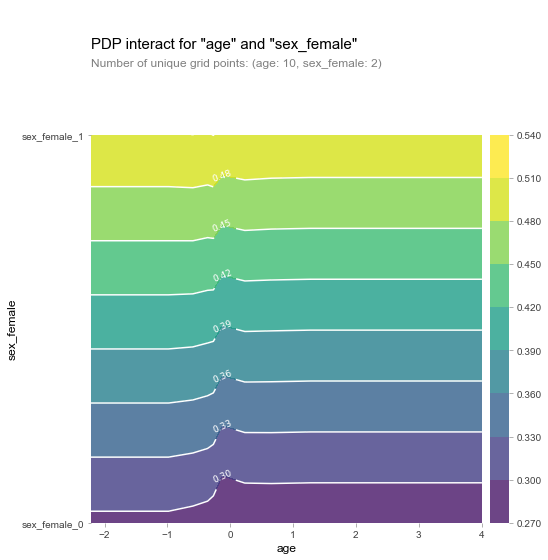

In [24]:
# we can also visualize the interaction between two features 

features = ['age', 'sex_female']
p = pdp.pdp_interact(rf5, X, X.columns, features)

fig, _ = pdp.pdp_interact_plot(p,features)

__Note__: The partial dependence plto pins down a feature value across the samples and then averages the results. (Be careful about outliers and means). Also, this plot assuemes features are independent. (Not always the case, for example, holding width of a sepal steady would probably have an effect on the height). The pdpbox also prints out the individual conditional expectations to better visualize these relationships. 

## Surrogate Models

If you have a model that is not interpretable (SVM or neural network), you can fit an interpretable model (decision tree) to that model. Using the surrogate you can examine the features importances. 

Here we create a Support Vector Classifier (SVC), but train a decision tree (without a depth limit to overfit and capture what is happening in this model) to explain it:

In [27]:
from sklearn import svm 

sv = svm.SVC()
sv.fit(X_train, y_train)
sur_dt = DecisionTreeClassifier()
sur_dt.fit(X_test, sv.predict(X_test))
for col, val in sorted(zip(X_test.columns, sur_dt.feature_importances_), key = lambda x:x[1], reverse = True)[:7]:
    print(f'{col:10}{val:10.3f}')

sex_female     0.571
pclass         0.174
embarked_S     0.116
fare           0.056
age            0.052
embarked_C     0.020
parch          0.009


## Shapley

The SHapley Additive exPlantations (SHAP) package can visualize feature contributions of any model. This is really nice package because not only does it work with most models, it also can explain individual predictions and the global feature contributions. 

SHAP works for both classification and regression. It generates SHAP values. For classification models, the SHAP value sums to log odds for binary classification. For regression, the SHAP values sum to the target prediction. 

This library requires Jupyter for interactivity on some of its plots. 


In [28]:
# Here is an example for sample 20, predicted to die
rf5.predict_proba(X_test.iloc[[20]])

array([[0.5878123, 0.4121877]])

In the force plot for sample 20, you can see the 'base value'. This is a famele who is predicted to die. We will use the survival index (1) because we want the right-hand side of the plot to be survival. The features push this to the right or left. The larger the feature, the more impact it has. In this case, the low fare and third class pusj towards death (the output value is below .5) 

In [32]:
import shap 
 
shap.initjs()
s = shap.TreeExplainer(rf5)
shap_vals = s.shap_values(X_test)
target_idx = 1
shap.force_plot(
                s.expected_value[target_idx],
                shap_vals[target_idx][20, :],
                feature_names=X_test.columns)


You can also visualize the explanations for the entire dataset (rotating them by 90 and plotting them alogn the x axis)

In [33]:
shap.initjs()
shap.force_plot(
                s.expected_value[1],
                shap_vals[1],
                feature_names=X_test.columns)

The SHAP library can also generate dependence plots. The following plot visualizes the relationship between age and SHAP value (it is colored by pclass, which SHAP choses automatically; specify a column name as `interaction_index` parameter to choose your own):

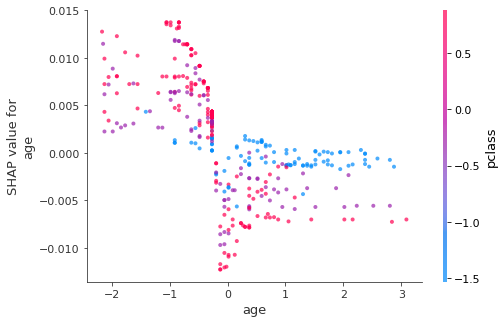

In [35]:
res = shap.dependence_plot(
                            'age',
                            shap_vals[target_idx],
                            X_test, 
                            feature_names=X_test.columns,
                            alpha = 0.7)

__TIP__ You might get a dependence plot that has veritcal lines. Setting the `x_jitter` parameter to 1 is useful if you are viewing ordinal categorical features. 


In addition, we can summarize all of the features. This is a very powerful chart to undestand. It shows global impact, but also individual impacts. The featues are ranked by importance. The most important features are at the top. 

Also the features are colored accoridng to their value. We can see that a low `sex_male` score (female) has a strong push toward survival, while high score has a less strong push toward death (for us is the opposite since we have `sex_female`). The age feature is a little harder to interpret. That is because young and old values push towards survival while middle values push towards death.

When you combine that summary plot with the dependence plot, you can get good insight into model behaviour. 

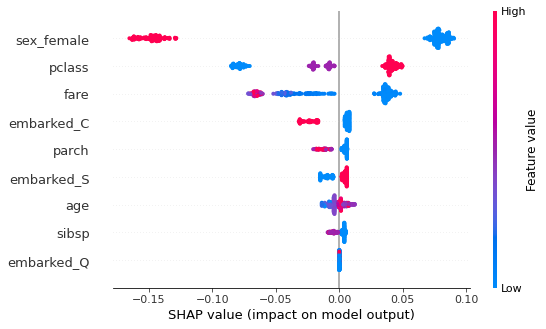

In [36]:
shap.summary_plot(shap_vals[0], X_test)